In [4]:
import os
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from utils import *

import math

from triangulation import ProbabilisticTriangulation,cal_mpjpe_batch
from calibration import CalibrationBatch
from torch.utils.data import Dataset, DataLoader

from dataset import H36M, H36MPred
import torch
import torch.nn as nn
import numpy as np
import cv2
from utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
cfg = {
    "nB":32,
    "nV":4,
    "M":32,
    "isDistr": False,
    "cube_min": [-0.16, -0.22, 0],
    "cube_max" : [0.22, 0.28, 0.21],
    "cube_shape": [64,64,32],
}

In [ ]:
h36m = H36MPred()
h36mloader = DataLoader(h36m, batch_size = cfg["nB"], shuffle = True)
db = []
for iter_i, batch in tqdm(enumerate(h36mloader)):
    calibr = CalibrationBatch(cfg,batch['pose_2d_pred'],batch['confidence'])
    weights_log = calibr.monte_carlo()
    R,t = calibr.prob_tri.getbuffer_Rt()
    for j in range(cfg["nB"]):
        db.append({
            'pose_3d' : batch['pose_3d'][j],
            'pose_2d_pred': batch['pose_2d_pred'][j],
            'Rpred': R.quan[:,j],
            'tpred': t.vector[:,j],
            'Rgt': batch['Rgt'][j],
            'tgt': batch['tgt'][j],
        })

69it [43:29, 37.76s/it]

In [ ]:
np.save('after_monte.npy', np.asarray(db))

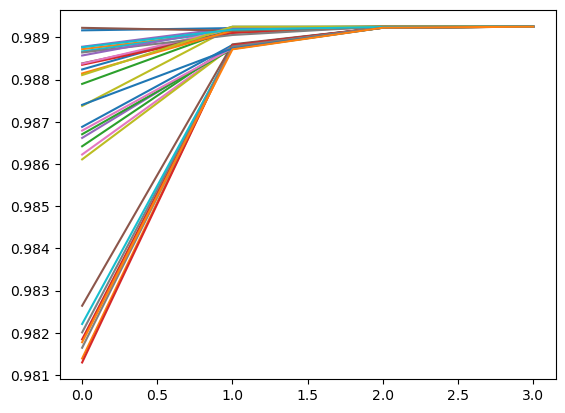

In [7]:
draw_db = torch.stack(weights_log, dim=0)[...,0]
plt.plot(draw_db)

In [ ]:
class Cube(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cube_min = torch.tensor(cfg["cube_min"])
        self.cube_max = torch.tensor(cfg["cube_max"])
        self.nB = cfg['nB']
        self.cube_shape = cfg['cube_shape']
        cube = []
        for i in range(self.cube_shape[0]):
            for j in range(self.cube_shape[1]):
                for k in range(self.cube_shape[2]):
                    cube.append([i,j,k])
        # (B,Np,3)
        self.cube = torch.tensor(cube.repeat(self.nB,1,1),requires_grad=False)
        self.cube = self.cube * (self.cube_max - self.cube_min)[None,None] + self.cube_min[None]

    def __call__(self, x, R, t, weights = None):
        """
        Args:
            x : (B,V,J,2)
            R : ((M),B,V,*)
            t : ((M),B,V,*)
            weights: (M,B)
            
        """
        if weights is not None:
            # (M,B,V,1,3,3)@(1,B,1,Np,3,1) + (M,B,V,1,3,1) -> (M,B,V,Np,3,1) -> (M,B,V,Np,2)
            reproj = homo_to_eulid( (R.matrix[:,:,:,None] @ self.cube[None,:,None,:,:,None] + t.trans[:,:,:,None]).squeeze(-1))
            # ((M,B,V,1,Np,2) - (1,B,V,J,1,2)) * (M,N,1,1,1,1) -> (M,B,V,J,Np,2) -> (B,V,J,Np,2)
            # (B,V,J,Np,2)**2 -> (B,V,J,Np,2) ** 2 -> (B,J,Np)
            mpjpe = (
                (reproj[:,:,:,None] - x[None,...,None,:])**2 * weights[...,None,None,None,None]
                ).sum(0) / weights.sum(0)[...,None,None,None,None]
                
            
        else:
            # (B,V,1,3,3)@(B,1,Np,3,1) + (B,V,1,3,1) -> (B,V,Np,3,1) -> (B,V,Np,2)
            reproj = homo_to_eulid( (R.matrix[:,:,None] @ self.cube[:,None,:,:,None] + t.trans[:,:,None]).squeeze(-1))
            # ((B,V,1,Np,2) - (B,V,J,1,2))**2 -> (B,V,J,Np,2) ** 2 -> (B,J,Np)
            mpjpe = (reproj[:,:,None] - x[...,None,:])**2
        
        mpjpe = mpjpe.sum(-4).sum(-1)
        mpjpe = mpjpe.view(self.nB,-1,*self.cube_shape)
        return torch.exp(- mpjpe)